<a href="https://colab.research.google.com/github/felisanmartin/MURA/blob/main/MURA_DenseNet121_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand Abnormality Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import random
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import os

In [142]:
train_df_origin = pd.read_csv("/content/drive/Othercomputers/macbookpro/MURA-v1.1/train_image_paths.csv", names = ["path"])
val_df_origin = pd.read_csv("/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid_image_paths.csv", names = ["path"])

In [143]:
train_df_origin.head()

path
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png

In [145]:
def get_label(path):
  if "positive" in path.split("/")[-2]:
    return 1
  if "negative" in path.split("/")[-2]:
    return 0

def get_bodypart(path):
  return path.split("/")[2]

def get_study(path):
  return str(path.split("/")[-3]) + "/" + str(path.split("/")[-2])

def get_patient(path):
  return str(path.split("/")[-3])

def set_df(df):
  labels = [get_label(i) for i in df.path]
  df["abnormality"] = labels
  bodyparts = [get_bodypart(i) for i in df.path]
  df["bodypart"] = bodyparts
  studies = [get_study(i) for i in df.path]
  df["study"] = studies
  patients = [get_patient(i) for i in df.path]
  df["patient"] = patients
  # Adding drive directory prefix
  paths = np.array(df.path)
  drive_prefix = "/content/drive/Othercomputers/macbookpro/"
  paths = drive_prefix + paths
  df["path"] = paths
  return df

In [146]:
train_df_origin = set_df(train_df_origin)
val_df_origin = set_df(val_df_origin)
train_df_origin

path  \
0      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png   
1      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png   
2      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png   
3      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png   
4      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png   
...                                                                                                             ...   
36803      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image2.png   
36804      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image3.png   
36805      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image1.png   
36806      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image2.png   
36807      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image3.png   

       abnormality     bodypart                         study       patient  
0                1  XR_SHOULDER  patient00001/study1_positive  patient00001  
1                1  XR_SHOULDER  patient00001/study1_positive  patient00001  
2                1  XR_SHOULDER  patient00001/study1_positive  patient00001  
3                1  XR_SHOULDER  patient00002/study1_positive  patient00002  
4                1  XR_SHOULDER  patient00002/study1_positive  patient00002  
...            ...          ...                           ...           ...  
36803            0      XR_HAND  patient11183/study1_negative  patient11183  
36804            0      XR_HAND  patient11183/study1_negative  patient11183  
36805            0      XR_HAND  patient11184/study1_negative  patient11184  
36806            0      XR_HAND  patient11184/study1_negative  patient11184  
36807            0      XR_HAND  patient11184/study1_negative  patient11184  

[36808 rows x 5 columns]

In [147]:
def isolate_bodypart(df, bodyparts):
  lst = np.zeros(len(df))
  for bodypart in bodyparts:
    lst += np.array(df["bodypart"] == bodypart)
  df = df[lst]
  df = df.reset_index().drop(["index"], axis = 1)
  return df

In [148]:
train_df_origin = train_df_origin[(train_df_origin["bodypart"] == "XR_HAND") + (train_df_origin["bodypart"] == "XR_FINGER") + (train_df_origin["bodypart"] == "XR_WRIST")]
train_df_origin = train_df_origin.reset_index().drop(["index"], axis = 1)
val_df_origin = val_df_origin[(val_df_origin["bodypart"] == "XR_HAND") + (val_df_origin["bodypart"] == "XR_FINGER") + (val_df_origin["bodypart"] == "XR_WRIST")]
val_df_origin = val_df_origin.reset_index().drop(["index"], axis = 1)

train_df_origin

path  \
0      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image1.png   
1      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image2.png   
2      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image3.png   
3      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03228/study1_positive/image1.png   
4      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03228/study1_positive/image2.png   
...                                                                                                           ...   
20396    /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image2.png   
20397    /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image3.png   
20398    /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image1.png   
20399    /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image2.png   
20400    /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image3.png   

       abnormality   bodypart                         study       patient  
0                1  XR_FINGER  patient03227/study1_positive  patient03227  
1                1  XR_FINGER  patient03227/study1_positive  patient03227  
2                1  XR_FINGER  patient03227/study1_positive  patient03227  
3                1  XR_FINGER  patient03228/study1_positive  patient03228  
4                1  XR_FINGER  patient03228/study1_positive  patient03228  
...            ...        ...                           ...           ...  
20396            0    XR_HAND  patient11183/study1_negative  patient11183  
20397            0    XR_HAND  patient11183/study1_negative  patient11183  
20398            0    XR_HAND  patient11184/study1_negative  patient11184  
20399            0    XR_HAND  patient11184/study1_negative  patient11184  
20400            0    XR_HAND  patient11184/study1_negative  patient11184  

[20401 rows x 5 columns]

In [149]:
train_patients_origin = pd.Series(train_df_origin['patient'].unique())
val_patients_origin = pd.Series(val_df_origin['patient'].unique())
patients = pd.DataFrame(pd.concat([train_patients_origin, val_patients_origin]), columns = ['patient'])
patients.reset_index(inplace=True, drop=True)
patients

patient
0     patient03227
1     patient03228
2     patient03229
3     patient02370
4     patient03230
...            ...
7087  patient11965
7088  patient11855
7089  patient11966
7090  patient11967
7091  patient11738

[7092 rows x 1 columns]

In [150]:
# Train test split
patients_train, patients_test = train_test_split(patients, test_size=0.2, shuffle=True, random_state=42)

In [151]:
paths_df = pd.concat([train_df_origin, val_df_origin])
train_df = pd.merge(paths_df, patients_train, how='inner', on='patient')
test_df = pd.merge(paths_df, patients_test, how='inner', on='patient')

In [152]:
print(len(test_df['patient'].unique()))
print(len(train_df['patient'].unique()))

1419
5673


In [153]:
test_df["abnormality"].value_counts()

0    2764
1    1644
Name: abnormality, dtype: int64

In [154]:
train_df["abnormality"].value_counts()

0    11047
1     6526
Name: abnormality, dtype: int64

## Data preprocessing

In [155]:
X_train = train_df["path"]
y_train = train_df["abnormality"]

X_test = test_df["path"]
y_test = test_df["abnormality"]

X_train, y_train

(0        /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image1.png
 1        /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image2.png
 2        /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image3.png
 3        /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03228/study1_positive/image1.png
 4        /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03228/study1_positive/image2.png
                                                             ...                                                    
 17568    /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11431/study1_negative/image3.png
 17569    /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11855/study1_negative/image1.png
 17570    /content/drive/Othercomputers/macbookpro/MURA-v1.1/val

In [156]:
IMG_SIZE = 320

def preprocess_image(path, label):
  # Reading image file
  img = tf.io.read_file(path)
  # Convert string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels = 3)
  # Convert color channel values from 0 - 255 values to 0 - 1 values
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE]), label

In [157]:
def preprocess_image_test(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_png(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

In [158]:
BATCH_SIZE = 32

def create_data(x, y = None, batch_size = BATCH_SIZE, val_data = False, test_data = False):
  if val_data: # Val data, no need to shuffle it
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                              tf.constant(y)))
    data = data.map(preprocess_image)
    data_batches = data.batch(BATCH_SIZE)
    return data_batches
  if test_data: # no labels
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data = data.map(preprocess_image_test)
    data_batches = data.batch(BATCH_SIZE)
    return data_batches
  else: # Train data
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # paths
                                               tf.constant(y))) # labels
    data = data.shuffle(buffer_size = len(x), seed = 42)
    data = data.map(preprocess_image)
    data_batches = data.batch(BATCH_SIZE)
    return data_batches

In [159]:
train_ds = create_data(X_train, y_train)
test_ds = create_data(X_test, y_test, val_data = True)

In [160]:
train_ds, test_ds

(<BatchDataset element_spec=(TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Plotting some images

In [161]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(12, 12))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(labels[i])
    # Turn gird lines off
    plt.axis("off")

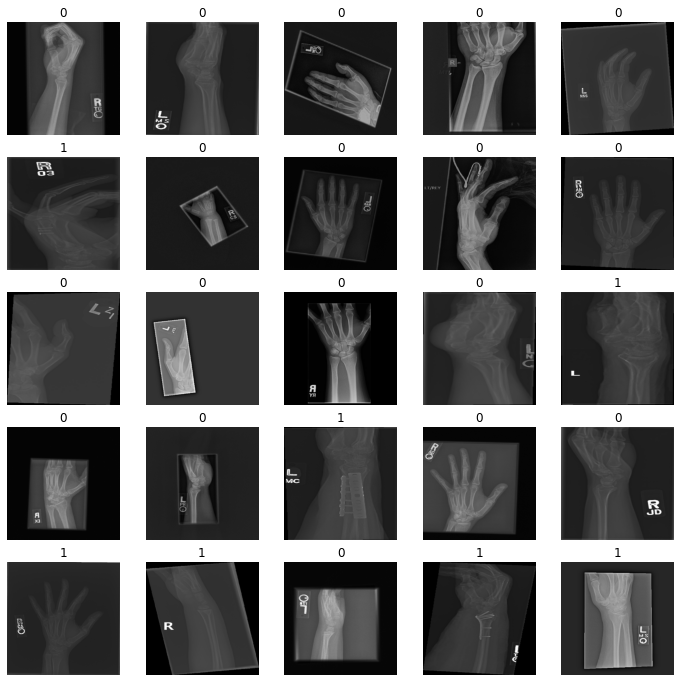

In [162]:
train_images, train_labels = next(train_ds.as_numpy_iterator())
show_25_images(train_images, train_labels)

## Model configuration

In [163]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = tf.keras.applications.densenet.DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 326, 326, 3)  0          ['input_7[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_12[0][0]']      
                                )                                                       

In [164]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [165]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'input_7'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.692339 to fit



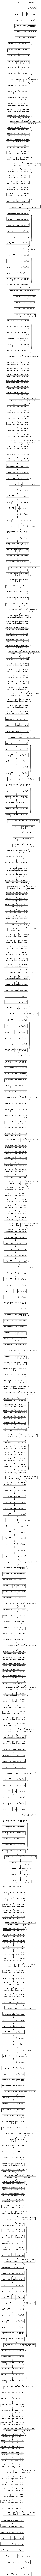

In [166]:
from keras.utils.vis_utils import plot_model
plot_model(base_model, to_file= "model_plot.png", show_shapes = True, show_layer_activations = True, show_layer_names = True)

In [167]:
#model = Sequential()
base_model = tf.keras.applications.densenet.DenseNet121(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(units = 5, kernel_regularizer = tf.keras.regularizers.L1(0.01))(x)
# x = tf.keras.layers.Dropout(0.2)(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer = 'adam', 
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [168]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_14 (ZeroPadding  (None, 326, 326, 3)  0          ['input_8[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_14[0][0]']      
                                )                                                           

In [169]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [170]:
import datetime

# Create function to build TensorBoard callback
def create_tensorboard_callback():
  logdir = os.path.join("drive/MyDrive/TFG/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M&S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [171]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience = 20) # stops after 6 rounds of no improvements

In [172]:
# Callbacks to save the epoch with best val_accuracy
checkpoint_filepath = "/content/drive/MyDrive/TFG/models/checkpoints"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Training The Model

In [173]:
tensorboard = create_tensorboard_callback()

epochs = 100
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs = epochs,  
    verbose = 1,
    callbacks = [tensorboard, early_stopping, model_checkpoint_callback]
)

Epoch 1/100
550/550 [==============================] - 143s 155ms/step - loss: 0.5727 - accuracy: 0.7097 - auc_3: 0.7335 - val_loss: 0.5826 - val_accuracy: 0.7375 - val_auc_3: 0.7765
Epoch 2/100
550/550 [==============================] - 82s 150ms/step - loss: 0.5052 - accuracy: 0.7611 - auc_3: 0.8048 - val_loss: 0.5535 - val_accuracy: 0.7416 - val_auc_3: 0.7762
Epoch 3/100
550/550 [==============================] - 81s 148ms/step - loss: 0.4912 - accuracy: 0.7660 - auc_3: 0.8186 - val_loss: 0.5935 - val_accuracy: 0.7330 - val_auc_3: 0.8064
Epoch 4/100
550/550 [==============================] - 83s 151ms/step - loss: 0.4663 - accuracy: 0.7874 - auc_3: 0.8389 - val_loss: 0.5209 - val_accuracy: 0.7495 - val_auc_3: 0.7912
Epoch 5/100
550/550 [==============================] - 83s 151ms/step - loss: 0.4549 - accuracy: 0.7949 - auc_3: 0.8461 - val_loss: 0.4828 - val_accuracy: 0.7872 - val_auc_3: 0.8263
Epoch 6/100
550/550 [==============================] - 82s 148ms/step - loss: 0.4388 - ac

In [174]:
model.load_weights(checkpoint_filepath)
model.save("/content/drive/MyDrive/TFG/models/mura_hand_last_v_dense121_20230313.h5")

## Visualizing training results

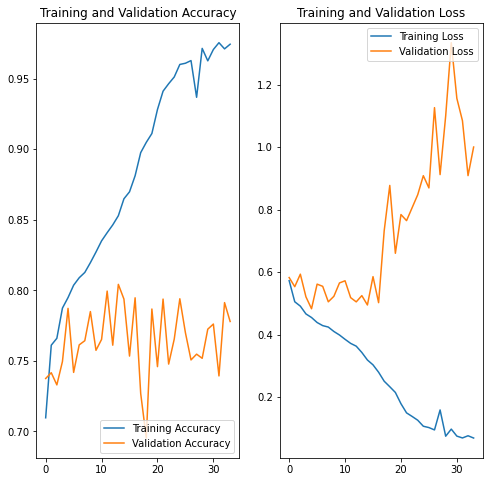

In [176]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
num_epochs = 34 # Manually insert
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluating the baseline model

In [177]:
# Loading saved model
model = tf.keras.models.load_model("/content/drive/MyDrive/TFG/models/mura_hand_last_v_dense121_20230313.h5", custom_objects={'KerasLayer': hub.KerasLayer})

In [185]:
# Making predictions on the validation set

pred_prob = model.predict(test_ds)

138/138 [==============================] - 5s 34ms/step


In [186]:
pred_prob

array([[0.81740165],
       [0.23550487],
       [0.83447415],
       ...,
       [0.03980603],
       [0.06021718],
       [0.04498432]], dtype=float32)

<AxesSubplot:xlabel='0', ylabel='Count'>

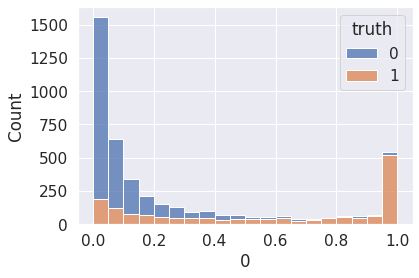

In [187]:
pred_prob_df = pd.DataFrame(pred_prob)
pred_prob_df['truth'] = y_test
sns.histplot(data = pred_prob_df, x=0, hue='truth', multiple='stack', bins=20)

In [188]:
predictions = []
for prob in pred_prob:
  if prob < 0.5:
    predictions.append(0)
  if prob >= 0.5:
    predictions.append(1)

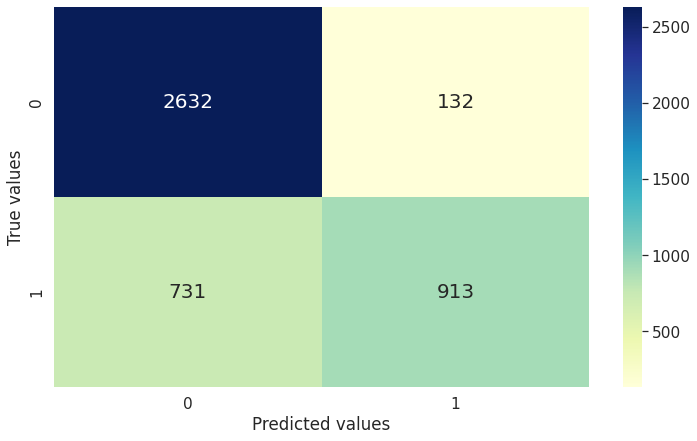

In [189]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize = (12, 7))
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot = True, annot_kws = {"size": 20}, cmap = "YlGnBu", fmt='d');
ax.set(xlabel = "Predicted values", ylabel = "True values")
plt.show;

In [191]:
print(classification_report(y_test, predictions, target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      2764
           1       0.87      0.56      0.68      1644

    accuracy                           0.80      4408
   macro avg       0.83      0.75      0.77      4408
weighted avg       0.82      0.80      0.79      4408



### ROC Curve

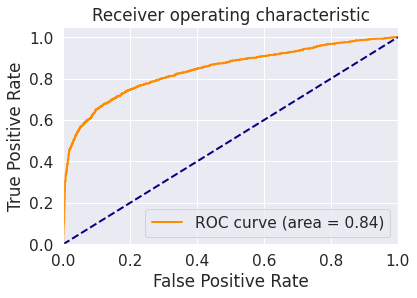

In [193]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, pred_prob)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % sklearn.metrics.auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [203]:
# To find the point closest to the top left corner
roc_array = np.column_stack((fpr, tpr, thresholds))

# Distance from point to top left corner is: sqrt((1-fpr)^2 + (1-tpr)^2)
distances = np.sqrt(np.square(fpr) + np.square((1-tpr)))
opt_threshold_index = np.argmin(distances)
optimal_threshold = thresholds[opt_threshold_index] 
print("Optimal threshold", optimal_threshold)

# Youden Index
roc_array_ = np.column_stack((fpr, tpr, thresholds))

distances_ = tpr - fpr

opt_threshold_index_ = np.argmax(distances_)
optimal_threshold = thresholds[opt_threshold_index_] 
print("Youden Index: ", optimal_threshold_)

Optimal threshold 0.17407925
Youden Index:  0.27031973


In [204]:
predictions = []
for prob in pred_prob:
  if prob < optimal_threshold:
    predictions.append(0)
  if prob >= optimal_threshold:
    predictions.append(1)

In [205]:
print(classification_report(y_test, predictions, target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2764
           1       0.77      0.68      0.72      1644

    accuracy                           0.80      4408
   macro avg       0.80      0.78      0.78      4408
weighted avg       0.80      0.80      0.80      4408



### Confusion matrix

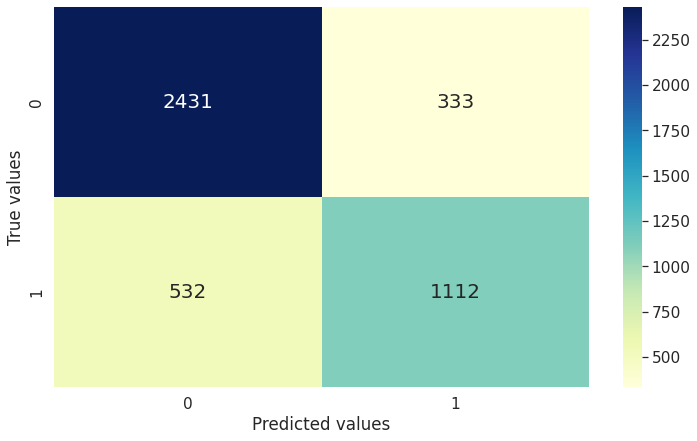

In [207]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize = (12, 7))
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot = True, annot_kws = {"size": 20}, cmap = "YlGnBu", fmt='d');
ax.set(xlabel = "Predicted values", ylabel = "True values")
plt.show;

In [208]:
print(cm)
print(707 + 551)
print(1258/1580)
551/731

[[2431  333]
 [ 532 1112]]
1258
0.7962025316455696


0.7537619699042407

## Unbatchifying validation dataset

In [209]:
# Unbatchify data
def unbatchify(data):
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)
  return images, labels

# Unbatch val data
test_images, test_labels = unbatchify(test_ds)
sum(test_labels)

1644

## Plotting predictions

In [210]:
def get_pred_label(prob, threshold = optimal_threshold):
  if prob > threshold:
    prediction = 1
  if prob <= threshold:
    prediction = 0
  return prediction

In [219]:
def plot_pred(prediction_probabilities, labels, images):
  n = random.randint(0, len(labels))
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change color of title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

In [220]:
random.randint(0, len(test_labels))

2369

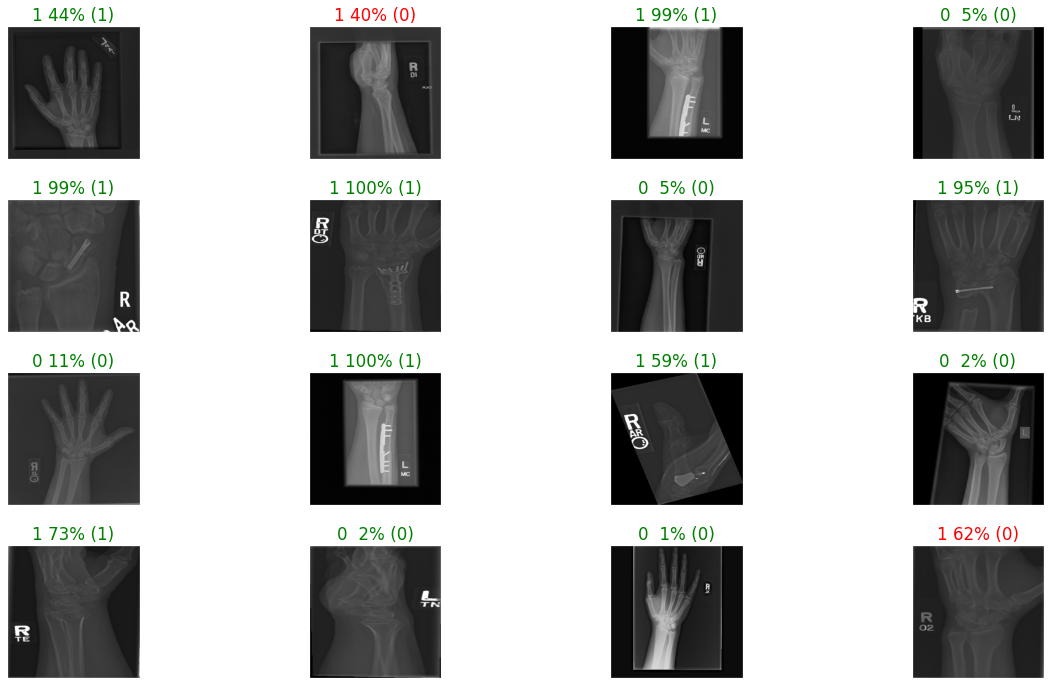

In [223]:
# Let's check a few random predictions and their different values
i_multiplier = 20
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
random_image_index = random.sample(range(0, len(test_labels)), num_images)
plt.figure(figsize=(17, 10))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=pred_prob,
            labels=test_labels,
            images=test_images)
plt.tight_layout(h_pad=1.0)
plt.show()

## Changing from Image Predictions to Study Predictions

In [225]:
predictions_df = pd.DataFrame(data = np.column_stack((X_test, test_labels, predictions, pred_prob)), columns = ["Path", "True Label", "Predicted Label", "Pred Score"])
predictions_df

Path  \
0     /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03233/study1_positive/image1.png   
1     /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03233/study1_positive/image2.png   
2     /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03233/study1_positive/image3.png   
3     /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03239/study1_positive/image1.png   
4     /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03239/study1_positive/image2.png   
...                                                                                                          ...   
4403  /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11966/study1_negative/image3.png   
4404  /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image1.png   
4405  /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image2.png   
4406  /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image3.png   
4407  /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image4.png   

     True Label Predicted Label Pred Score  
0             1               1   0.817402  
1             1               0   0.235505  
2             1               1   0.834474  
3             1               0   0.008889  
4             1               0   0.018329  
...         ...             ...        ...  
4403          0               0   0.008729  
4404          0               0   0.040227  
4405          0               0   0.039806  
4406          0               0   0.060217  
4407          0               0   0.044984  

[4408 rows x 4 columns]

In [226]:
predictions_studies = [get_study(i) for i in predictions_df["Path"]]
predictions_df["Study"] = predictions_studies

In [227]:
predictions_df

Path  \
0     /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03233/study1_positive/image1.png   
1     /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03233/study1_positive/image2.png   
2     /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03233/study1_positive/image3.png   
3     /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03239/study1_positive/image1.png   
4     /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03239/study1_positive/image2.png   
...                                                                                                          ...   
4403  /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11966/study1_negative/image3.png   
4404  /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image1.png   
4405  /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image2.png   
4406  /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image3.png   
4407  /content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image4.png   

     True Label Predicted Label Pred Score                         Study  
0             1               1   0.817402  patient03233/study1_positive  
1             1               0   0.235505  patient03233/study1_positive  
2             1               1   0.834474  patient03233/study1_positive  
3             1               0   0.008889  patient03239/study1_positive  
4             1               0   0.018329  patient03239/study1_positive  
...         ...             ...        ...                           ...  
4403          0               0   0.008729  patient11966/study1_negative  
4404          0               0   0.040227  patient11967/study1_negative  
4405          0               0   0.039806  patient11967/study1_negative  
4406          0               0   0.060217  patient11967/study1_negative  
4407          0               0   0.044984  patient11967/study1_negative  

[4408 rows x 5 columns]

In [228]:
study_df = predictions_df.groupby(["Study"]).mean()
study_df

<ipython-input-228-00ff3ed9b482>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  study_df = predictions_df.groupby(["Study"]).mean()


True Label  Predicted Label  Pred Score
Study                                                                
patient00011/study1_negative         0.0              0.0    0.013538
patient00054/study1_negative         0.0              0.0    0.066654
patient00077/study1_positive         1.0              1.0    0.993136
patient00147/study1_positive         1.0              1.0    0.999829
patient00147/study2_negative         0.0              0.0    0.028655
...                                  ...              ...         ...
patient11951/study1_negative         0.0              0.0    0.019332
patient11962/study1_negative         0.0              0.0    0.060924
patient11965/study1_negative         0.0              0.0    0.007521
patient11966/study1_negative         0.0              0.0    0.007406
patient11967/study1_negative         0.0              0.0    0.046309

[1541 rows x 3 columns]

<AxesSubplot:xlabel='Pred Score', ylabel='Count'>

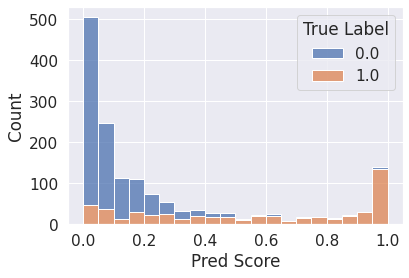

In [229]:
sns.histplot(data = study_df, x="Pred Score", hue='True Label', multiple='stack', bins=20)

In [240]:
threshold = 0.2513388792673747
new_predictions = []
for prob in study_df["Pred Score"]:
  if prob < threshold:
    new_predictions.append(0)
  if prob >= threshold:
    new_predictions.append(1)
study_df["Study Prediction"] = new_predictions

In [241]:
study_df

True Label  Predicted Label  Pred Score  \
Study                                                                   
patient00011/study1_negative         0.0              0.0    0.013538   
patient00054/study1_negative         0.0              0.0    0.066654   
patient00077/study1_positive         1.0              1.0    0.993136   
patient00147/study1_positive         1.0              1.0    0.999829   
patient00147/study2_negative         0.0              0.0    0.028655   
...                                  ...              ...         ...   
patient11951/study1_negative         0.0              0.0    0.019332   
patient11962/study1_negative         0.0              0.0    0.060924   
patient11965/study1_negative         0.0              0.0    0.007521   
patient11966/study1_negative         0.0              0.0    0.007406   
patient11967/study1_negative         0.0              0.0    0.046309   

                              Study Prediction  
Study                                           
patient00011/study1_negative                 0  
patient00054/study1_negative                 0  
patient00077/study1_positive                 1  
patient00147/study1_positive                 1  
patient00147/study2_negative                 0  
...                                        ...  
patient11951/study1_negative                 0  
patient11962/study1_negative                 0  
patient11965/study1_negative                 0  
patient11966/study1_negative                 0  
patient11967/study1_negative                 0  

[1541 rows x 4 columns]

In [242]:
print(classification_report(study_df["True Label"], study_df["Study Prediction"], target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1002
           1       0.79      0.72      0.75       539

    accuracy                           0.83      1541
   macro avg       0.82      0.81      0.81      1541
weighted avg       0.83      0.83      0.83      1541



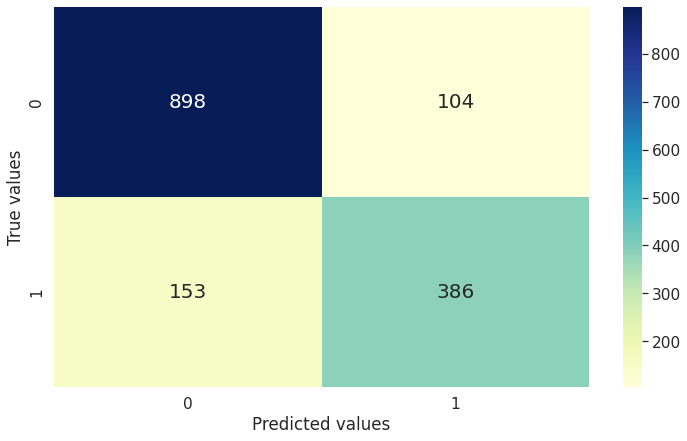

In [243]:
# Confusion matrix
cm = confusion_matrix(study_df["True Label"], study_df["Study Prediction"])
plt.figure(figsize = (12, 7))
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot = True, annot_kws = {"size": 20}, cmap = "YlGnBu", fmt='d');
ax.set(xlabel = "Predicted values", ylabel = "True values")
plt.show;

In [244]:
print(cm)
print(181 /(49 + 181))
print(433/534)

[[898 104]
 [153 386]]
0.7869565217391304
0.8108614232209738


In [245]:
study_df["True Label"]

Study
patient00011/study1_negative    0.0
patient00054/study1_negative    0.0
patient00077/study1_positive    1.0
patient00147/study1_positive    1.0
patient00147/study2_negative    0.0
                               ... 
patient11951/study1_negative    0.0
patient11962/study1_negative    0.0
patient11965/study1_negative    0.0
patient11966/study1_negative    0.0
patient11967/study1_negative    0.0
Name: True Label, Length: 1541, dtype: float64

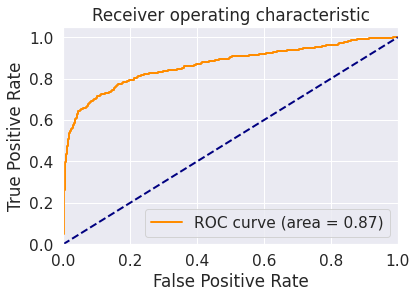

In [246]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(list(study_df["True Label"]), list(study_df["Pred Score"]))
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % sklearn.metrics.auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [247]:
# To find the point closest to the top left corner
roc_array = np.column_stack((fpr, tpr, thresholds))

# Distance from point to top left corner is: sqrt((1-fpr)^2 + (1-tpr)^2)
distances = np.sqrt(np.square(fpr) + np.square((1-tpr)))
opt_threshold_index = np.argmin(distances)
optimal_threshold = thresholds[opt_threshold_index] 
optimal_threshold

0.19245356072982153

In [248]:
# Youden Index
roc_array_ = np.column_stack((fpr, tpr, thresholds))

distances_ = tpr - fpr

opt_threshold_index_ = np.argmax(distances_)
optimal_threshold_ = thresholds[opt_threshold_index_] 
optimal_threshold_

0.2513388792673747

In [249]:
# Symmetry point
roc_array_2 = np.column_stack((fpr, tpr, thresholds))

distances_2 = tpr - (1 - fpr)

opt_threshold_index_2 = np.argmax(distances_2)
optimal_threshold_2 = thresholds[opt_threshold_index_2] 
optimal_threshold_2

thresholds[np.argmin(np.abs(distances_2))]

0.171726543456316

# Testing with new images

In [250]:
test_images_path = "/content/test_images/"
test_image_paths = [test_images_path + fname for fname in os.listdir(test_images_path)]

FileNotFoundError: ignored

In [ ]:
test_image_paths

['/content/test_images/fractura-mano-radiografia.jpeg',
 '/content/test_images/image2.png']

In [ ]:
test_ds = create_data(test_image_paths, test_data = True)

In [ ]:
model.predict(test_ds)

1/1 [==============================] - 0s 136ms/step


array([[0.0370291],
       [0.7637861]], dtype=float32)

In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/test-images/"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
def show_25_images_test(images):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(12, 12))
  # Loop through 25 (for displaying 25 images)
  for i in range(len(images)):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Turn gird lines off
    plt.axis("off")

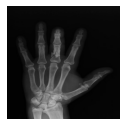

In [ ]:
test_images = next(test_ds.as_numpy_iterator())
show_25_images_test(test_images)